<a href="https://colab.research.google.com/github/allythe/Alg_Struct_of_Data_FALT2022/blob/main/DatasetFromCVAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brief outline

In this document, we implement a pipeline for extracting frames from videos to create a dataset. The videos must be stored in Google Drive together with their corresponding XML annotation files. When annotating data in CVAT, export the annotations using the CVAT Images format and upload the resulting XML file to your Google Drive.
The script does not extract every frame; instead, it selects only frames that are sufficiently different from each other to avoid redundancy.


# Mount your Google Drive with videos and annotations

In [1]:
import os
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from tqdm import tqdm

In [2]:
# mount your GDrive disk
from google.colab import drive
drive.mount("/content/drive/")

# go to the dir with videos folder
!ls /content/drive/MyDrive/MIUN/QRD/implementation/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
 Algorithms.ipynb
 Analysis.ipynb
 DatasetFromCVAT.ipynb
'horizon_coordinates_all (1).gsheet'
 horizon_coordinates_all.csv
 horizon_coordinates_all.gsheet
 horizon_detection_h_cov_lum_results.csv
 horizon_detection_h_hc_results.csv
 horizon_detection_h_lsc_results.csv
 images
 results
 resultshorizon_dexined_analysis_results.csv
 resultshorizon_h_cov_lum_analysis_results.csv
 resultshorizon_h_med_analysis_results.csv
 resultshorizon_segment_analysis_results.csv
 videos


# Find video and annotation file

In [3]:
# write the word which is contained in both xml and video filenames strings
string_contained_in_video_name = "fifth"

# prefix which all the extracted images will have
name_data = "drone_ice_5"

In [4]:
# go to the folder where videos and xml files are stored
VIDEO_DIR = "/content/drive/MyDrive/MIUN/QRD/implementation/videos"

ann_filename = None
video_filename = None

for f in os.listdir(VIDEO_DIR):
    if f.lower().endswith(".xml") and string_contained_in_video_name in f.lower():
        ann_filename = os.path.join(VIDEO_DIR, f)
    elif f.lower().endswith((".webm", ".mp4", ".avi", ".mov")) and string_contained_in_video_name in f.lower():
        video_filename = os.path.join(VIDEO_DIR, f)

if not ann_filename or not video_filename:
    raise FileNotFoundError("Could not find .xml and video file in the 'videos' folder!")

print(f"Found annotation: {ann_filename}")
print(f"Found video: {video_filename}")


Found annotation: /content/drive/MyDrive/MIUN/QRD/implementation/videos/fifth_video.xml
Found video: /content/drive/MyDrive/MIUN/QRD/implementation/videos/fifth_video.mp4


# Parse annotations, keep only those which have horizon

In [5]:
# not all frames can have annotations, so keep only those frames which have
def parse_cvat_xml(path, target_label="horizon"):
    """Return dict: {frame_id: [ [x1,y1], [x2,y2], ... ]}"""
    tree = ET.parse(path)
    root = tree.getroot()
    frame_polylines = {}

    for image_tag in root.findall(".//image"):
        frame_id = int(image_tag.attrib["id"])
        polylines = []
        for poly_tag in image_tag.findall(".//polyline"):
            label = poly_tag.attrib.get("label", "").lower()
            if label == target_label:
                pts_str = poly_tag.attrib["points"]
                pts = [list(map(float, p.split(","))) for p in pts_str.strip().split(";")]
                polylines.append(pts)
        if polylines:
            frame_polylines[frame_id] = polylines

    return frame_polylines

horizons = parse_cvat_xml(ann_filename)
print(f" Parsed {len(horizons)} frames with horizon annotations.")

 Parsed 116 frames with horizon annotations.


In [6]:
cap = cv2.VideoCapture(video_filename)
if not cap.isOpened():
    raise RuntimeError(f"❌ Cannot open video file: {video_filename}")

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"🎞️ Total frames in video: {total_frames}")

🎞️ Total frames in video: 929


# Let's check if horizon marking is aligned with frames in video


Checking video frame 136


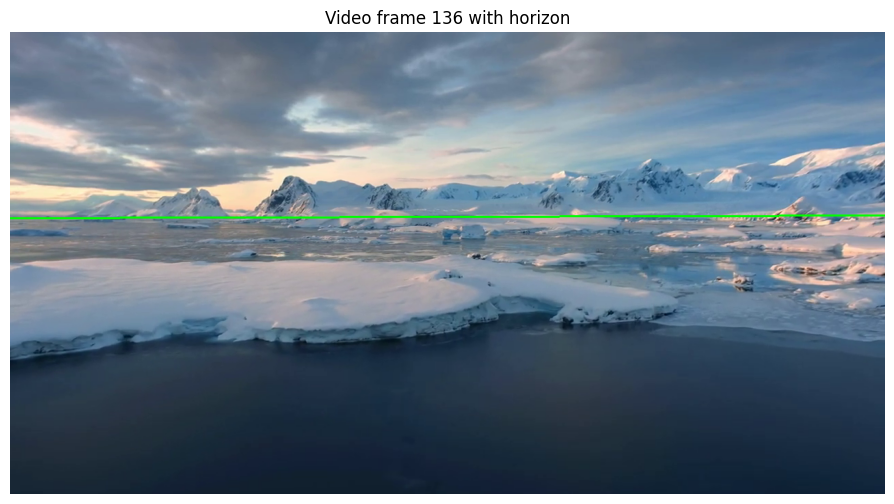

In [7]:
# pick n-th frame to check if the horizon is correct

n = 17  # pick the nth annotated frame to check
annotated_frames = sorted(horizons.keys())
frame_id = annotated_frames[n]  # directly the real video frame

print(f"Checking video frame {frame_id}")

cap = cv2.VideoCapture(video_filename)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
ret, frame = cap.read()
cap.release()

if not ret:
    raise RuntimeError(f"Could not read frame {frame_id} from video!")

for pts in horizons[frame_id]:
    pts_int = np.array(pts, np.int32)
    cv2.polylines(frame, [pts_int], isClosed=False, color=(0,255,0), thickness=2)

plt.figure(figsize=(12,6))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title(f"Video frame {frame_id} with horizon")
plt.axis("off")
plt.show()

# Extract frames and save them

In [8]:
# Output folder in Google Drive
output_dir = "/content/drive/MyDrive/MIUN/QRD/implementation/images"
os.makedirs(output_dir, exist_ok=True)

def is_similar(img1, img2, threshold=30):
    """Return True if two images are visually similar based on mean pixel difference."""
    if img1.shape != img2.shape:
        return False
    diff = cv2.absdiff(img1, img2)
    mean_diff = np.mean(diff)
    return mean_diff < threshold

annotated_frames = sorted(horizons.keys())
csv_rows = []

cap = cv2.VideoCapture(video_filename)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

prev_frame_small = None
for i, frame_id in enumerate(tqdm(annotated_frames, desc="Extracting frames")):
    if frame_id >= total_frames:
        continue

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
    ret, frame = cap.read()
    if not ret:
        continue

    frame_small = cv2.resize(frame, (320, 180))
    if prev_frame_small is not None and is_similar(frame_small, prev_frame_small, threshold=7):
        continue

    out_filename = f"{name_data}_img_{frame_id:06d}.jpeg"
    out_path = os.path.join(output_dir, out_filename)
    # cv2.imwrite(out_path, frame)

    # Collect horizon coordinates
    for j, pts in enumerate(horizons[frame_id]):
        for k, (x, y) in enumerate(pts):
            csv_rows.append({
                "image_filename": out_filename,
                "frame_index": frame_id,
                "polyline_id": j,
                "point_index": k,
                "x": x,
                "y": y
            })

    prev_frame_small = frame_small.copy()

cap.release()

# Save horizon coordinates CSV
csv_path = os.path.join(output_dir, f"horizon_coordinates_{name_data}.csv")
df = pd.DataFrame(csv_rows)
# df.to_csv(csv_path, index=False)

print(f"Saved {len(csv_rows)} horizon points and images to '{output_dir}/'.")

csv_path = os.path.join(output_dir, f"horizon_coordinates_{name_data}.csv")
df = pd.DataFrame(csv_rows)
df.to_csv(csv_path, index=False)
print(f"Saved {len(df)} coordinate points to {csv_path}")

Extracting frames: 100%|██████████| 116/116 [00:33<00:00,  3.51it/s]

Saved 58 horizon points and images to '/content/drive/MyDrive/MIUN/QRD/implementation/images/'.
Saved 58 coordinate points to /content/drive/MyDrive/MIUN/QRD/implementation/images/horizon_coordinates_drone_ice_5.csv


# Unite all the csv with gt horizon to one file

The coordinates csv are created for each video separately, so you might need to unite them in one csv for the ease of use

In [9]:
def combine_gt_horizon_files(gt_folder, output_csv=None):
    """
    Combine all GT horizon coordinate files using column names from the first file.
    """
    all_files = sorted([
        os.path.join(gt_folder, f)
        for f in os.listdir(gt_folder)
        if f.startswith("horizon_coordinates_") and f.endswith(".csv")
    ])

    if not all_files:
        raise FileNotFoundError(f"No GT files found in {gt_folder}")

    first_file = all_files[0]
    first_df = pd.read_csv(first_file)
    col_names = first_df.columns.tolist()
    dfs = [first_df]

    print(f"Using columns from {os.path.basename(first_file)}: {col_names}")

    for f in all_files[1:]:
        try:
            df = pd.read_csv(f, names=col_names, header=0)  # enforce same columns
            dfs.append(df)
            print(f"Loaded {os.path.basename(f)} ({len(df)} rows)")
        except Exception as e:
            print(f"Skipping {f} due to error: {e}")

    combined_df = pd.concat(dfs, ignore_index=True)
    combined_df = combined_df.drop_duplicates(subset=["image_filename", "point_index", "x", "y"], keep="first")

    if output_csv:
        combined_df.to_csv(output_csv, index=False)
        print(f"Combined GT file saved to {output_csv}")

    print(f"Total rows combined: {len(combined_df)} from {len(all_files)} files")
    return combined_df

In [10]:
gt_folder = "/content/drive/MyDrive/MIUN/QRD/implementation/images"
output_csv = "/content/drive/MyDrive/MIUN/QRD/implementation/horizon_coordinates_all.csv"

gt_df = combine_gt_horizon_files(gt_folder, output_csv)

Using columns from horizon_coordinates_boat_ice_1.csv: ['image_filename', 'frame_index', 'polyline_id', 'point_index', 'x', 'y']
Loaded horizon_coordinates_boat_ice_2.csv (105 rows)
Loaded horizon_coordinates_boat_ice_3.csv (454 rows)
Loaded horizon_coordinates_drone_ice_4.csv (47 rows)
Loaded horizon_coordinates_drone_ice_5.csv (58 rows)
Loaded horizon_coordinates_drone_ice_6.csv (140 rows)
Loaded horizon_coordinates_drone_ice_cropped_4.csv (34 rows)
Combined GT file saved to /content/drive/MyDrive/MIUN/QRD/implementation/horizon_coordinates_all.csv
Total rows combined: 1695 from 7 files


# Take random image from the all coordinates csv file and draw the horizon

In [11]:
def draw_random_gt_horizon(gt_csv_path, images_folder):
    df_gt = pd.read_csv(gt_csv_path)
    df_gt['image_filename'] = df_gt['image_filename'].astype(str)

    random_image = random.choice(df_gt['image_filename'].unique())
    df_img = df_gt[df_gt['image_filename'] == random_image].sort_values('x')

    image_path = os.path.join(images_folder, random_image)
    if not os.path.exists(image_path):
        print(f" Image not found: {image_path}")
        return

    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    gt_points = df_img[['x', 'y']].dropna().values.astype(int)
    if len(gt_points) >= 2:
        cv2.polylines(img_rgb, [gt_points.reshape(-1, 1, 2)], False, (255, 0, 0), 4)
    else:
        print(f" Not enough points for horizon in {random_image}")
        return


    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.title(f"Horizon for {random_image}")
    plt.axis("off")
    plt.show()

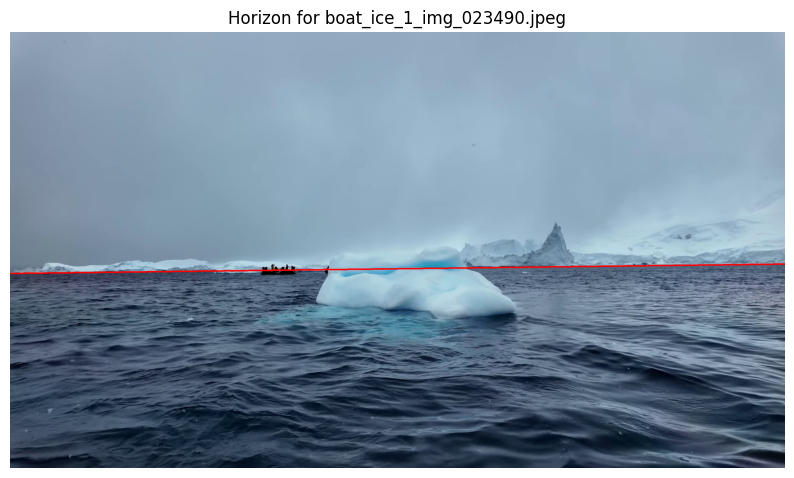

In [12]:
gt_csv = "/content/drive/MyDrive/MIUN/QRD/implementation/horizon_coordinates_all.csv"
images_folder = "/content/drive/MyDrive/MIUN/QRD/implementation/images"

draw_random_gt_horizon(gt_csv, images_folder)